In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

import os
import mido
import pretty_midi as pm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

import tensorflow as tf
# import torch as pt
import joblib
import streamlit as st

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Things to check: 
- are all midi files being pulled 

In [34]:
file_path = 'C:\\Users\\gabri\\OneDrive\\Desktop\\MSAAI\\AAI-511\\aai-511_group1\\midiclassics'

In [35]:
# def extract_basic_features(file_path):
#     mid = mido.MidiFile(file_path)
#     features = {
#         'file_name': os.path.basename(file_path),
#         'num_tracks': len(mid.tracks),
#         'ticks_per_beat': mid.ticks_per_beat,
#         'length': mid.length,
#     }
#     return features

# def extract_pretty_midi_features(file_path):
#     midi_data = pm.PrettyMIDI(file_path)
#     features = {
#         'num_notes': sum(len(instrument.notes) for instrument in midi_data.instruments),
#         'note_density': sum(len(instrument.notes) for instrument in midi_data.instruments) / midi_data.get_end_time(),
#         'avg_velocity': (sum(note.velocity for instrument in midi_data.instruments for note in instrument.notes) /
#                          sum(len(instrument.notes) for instrument in midi_data.instruments)),
#         'key_signature': None,
#         'time_signature': None,
#         'tempo': None
#     }
    
#     if midi_data.key_signature_changes:
#         try:
#             features['key_signature'] = midi_data.key_signature_changes[0].key_number
#         except KeyError:
#             features['key_signature'] = 'Unknown'
    
#     if midi_data.time_signature_changes:
#         features['time_signature'] = str(midi_data.time_signature_changes[0])
    
#     if midi_data.get_tempo_changes()[1].size > 0:
#         features['tempo'] = midi_data.get_tempo_changes()[1][0]
    
#     return features

# def get_composer_from_filename(file_path):
#     return os.path.basename(file_path).split('_')[0]

# def load_midi_files_to_dataframe(directory_path, composer):
#     midi_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.mid')]
#     data = []
#     for file in midi_files:
#         try:
#             basic_features = extract_basic_features(file)
#             pretty_midi_features = extract_pretty_midi_features(file)
#             features = {**basic_features, **pretty_midi_features, 'composer': composer}
#             data.append(features)
#         except Exception as e:
#             print(f"Error processing file {file}: {e}")
#     df = pd.DataFrame(data)
#     return df

In [36]:
def extract_basic_features(file_path):
    mid = mido.MidiFile(file_path)
    features = {
        'file_name': os.path.basename(file_path),
        'num_tracks': len(mid.tracks),
        'ticks_per_beat': mid.ticks_per_beat,
        'length': mid.length,
    }
    return features

def extract_pretty_midi_features(file_path):
    midi_data = pm.PrettyMIDI(file_path)
    pitches = []
    
    # Gather all pitches from all instruments
    for instrument in midi_data.instruments:
        pitches.extend([note.pitch for note in instrument.notes])
    
    # Calculate pitch-related features
    if pitches:
        pitch_features = {
            'min_pitch': min(pitches),
            'max_pitch': max(pitches),
            'avg_pitch': sum(pitches) / len(pitches),
            'most_common_pitch': max(set(pitches), key=pitches.count)
        }
    else:
        pitch_features = {
            'min_pitch': None,
            'max_pitch': None,
            'avg_pitch': None,
            'most_common_pitch': None
        }
    
    # Extract other features as before
    features = {
        'num_notes': len(pitches),
        'note_density': len(pitches) / midi_data.get_end_time() if midi_data.get_end_time() > 0 else None,
        'avg_velocity': (sum(note.velocity for instrument in midi_data.instruments for note in instrument.notes) /
                         len(pitches)) if pitches else None,
        'key_signature': None,
        'time_signature': None,
        'tempo': None
    }
    
    # Update features with pitch-related data
    features.update(pitch_features)
    
    # Key Signature
    if midi_data.key_signature_changes:
        features['key_signature'] = midi_data.key_signature_changes[0].key_number
    
    # Time Signature
    if midi_data.time_signature_changes:
        time_sig = midi_data.time_signature_changes[0]
        features['time_signature'] = f"{time_sig.numerator}/{time_sig.denominator}"
    
    # Tempo
    tempos = midi_data.get_tempo_changes()[1]
    if tempos.size > 0:
        features['tempo'] = tempos[0]  # Extract the first tempo

    return features

In [37]:
def get_composer_from_filename(file_path):
    return os.path.basename(file_path).split('_')[0]

def load_midi_files_to_dataframe(directory_path, composer):
    midi_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.lower().endswith(('.mid', '.midi'))]
    data = []
    for file in midi_files:
        try:
            basic_features = extract_basic_features(file)
            pretty_midi_features = extract_pretty_midi_features(file)
            features = {**basic_features, **pretty_midi_features, 'composer': composer}
            data.append(features)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    df = pd.DataFrame(data)
    return df

In [38]:
# Specify the parent directory containing composer folders
file_path = 'C:\\Users\\gabri\\OneDrive\\Desktop\\MSAAI\\AAI-511\\aai-511_group1\\midiclassics'

# List of composers (folder names)
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Dictionary to hold DataFrames for each composer
composer_dataframes = {}

# Process each composer's folder
for composer in composers:
    composer_folder = os.path.join(file_path, composer)
    composer_df = load_midi_files_to_dataframe(composer_folder, composer)
    composer_dataframes[composer] = composer_df
    print(f"{composer} DataFrame:")
    print(composer_df.head())

# Merge all DataFrames into a single DataFrame
all_composers_df = pd.concat(composer_dataframes.values(), ignore_index=True)

# Display the merged DataFrame
print("Merged DataFrame:")
print(all_composers_df.head())

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Bach DataFrame:
      file_name  num_tracks  ticks_per_beat     length  num_notes  \
0  003706b_.mid           5            1024  46.956456        304   
1  003806b_.mid           5            1024  45.000610        253   
2  003907bv.mid           5            1024  42.500610        285   
3  003907b_.mid           5            1024  42.500610        285   
4  004003b_.mid           5            1024  30.000000        204   

   note_density  avg_velocity  key_signature time_signature      tempo  \
0      6.474083          96.0            9.0            4/4  92.000129   
1      5.622222          96.0           21.0            4/4  96.000000   
2      6.705882          96.0            7.0            4/4  96.000000   
3      6.705882          96.0           10.0            4/4  96.000000   
4      6.800000          96.0           19.0            4/4  96.000000   

   min_pitch  max_pitch  avg_pitch  most_common_pitch composer  
0         45         76  60.944079                 64     B

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Beethoven DataFrame:
                      file_name  num_tracks  ticks_per_beat      length  \
0                       122.MID           3             384  397.827695   
1                        13.MID          35             240  637.214819   
2                       134.MID          11             240  426.351189   
3                       136.MID           5              48  663.034478   
4  32 Variations on a theme.mid           4             480  618.942806   

   num_notes  note_density  avg_velocity  key_signature time_signature  \
0       6311     15.914497     57.231817            NaN            4/4   
1      36637     57.495524    103.136829            NaN            4/4   
2       7220     17.032525     49.801939            NaN            2/4   
3       8437     12.724828     64.913239           10.0            3/4   
4       7318     11.823386     69.349412            0.0            3/4   

        tempo  min_pitch  max_pitch  avg_pitch  most_common_pitch   composer  
0  2

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Chopin DataFrame:
                                           file_name  num_tracks  \
0   (2542)Prelude opus.28, No.16 in B flat minor.mid           2   
1  19 Polish Songs, for Solo Voice and Piano acco...           3   
2  19 Polish Songs, for Solo Voice and Piano acco...           3   
3  19 Polish Songs, for Solo Voice and Piano acco...           3   
4  19 Polish Songs, for Solo Voice and Piano acco...           3   

   ticks_per_beat      length  num_notes  note_density  avg_velocity  \
0            1024   64.000262       1199     18.734394     63.552961   
1             480  108.675018       1742     16.142204     97.889782   
2             480   58.162016        669     11.527386     87.372197   
3             480  122.586853        682      5.587330    100.079179   
4             480  241.889534       1062      4.391190    100.000000   

   key_signature time_signature       tempo  min_pitch  max_pitch  avg_pitch  \
0           22.0            6/4  180.000180         27      

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing file C:\Users\gabri\OneDrive\Desktop\MSAAI\AAI-511\aai-511_group1\midiclassics\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Mozart DataFrame:
                           file_name  num_tracks  ticks_per_beat      length  \
0        A piece for Piano,K.176.mid           4             240  116.503280   
1               Adagio in B flat.mid           6             480  716.505484   
2  Another piece for Piano,K.176.mid           4             240  128.892212   
3                 Contradance n1.mid           3             120   34.904511   
4                 Contradance n2.mid           3             120   59.256950   

   num_notes  note_density  avg_velocity  key_signature time_signature  \
0        881      7.577629     64.000000            NaN            3/4   
1       3332      4.650348     81.130552            2.0            4/4   
2       1139      8.836841     64.000000            NaN            3/4   
3        302      8.65217

In [39]:
all_composers_df.head()

,file_name,num_tracks,ticks_per_beat,length,num_notes,note_density,avg_velocity,key_signature,time_signature,tempo,min_pitch,max_pitch,avg_pitch,most_common_pitch,composer
0,003706b_.mid,5,1024,46.956456,304,6.474083,96.0,9.0,4/4,92.000129,45,76,60.944079,64,Bach
1,003806b_.mid,5,1024,45.000610,253,5.622222,96.0,21.0,4/4,96.000000,38,74,60.992095,64,Bach
2,003907bv.mid,5,1024,42.500610,285,6.705882,96.0,7.0,4/4,96.000000,40,76,59.182456,62,Bach
3,003907b_.mid,5,1024,42.500610,285,6.705882,96.0,10.0,4/4,96.000000,43,79,62.182456,65,Bach
4,004003b_.mid,5,1024,30.000000,204,6.800000,96.0,19.0,4/4,96.000000,42,74,61.220588,67,Bach


In [40]:
all_composers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1627 entries, 0 to 1626
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   file_name          1627 non-null   object 
 1   num_tracks         1627 non-null   int64  
 2   ticks_per_beat     1627 non-null   int64  
 3   length             1627 non-null   float64
 4   num_notes          1627 non-null   int64  
 5   note_density       1627 non-null   float64
 6   avg_velocity       1627 non-null   float64
 7   key_signature      1351 non-null   float64
 8   time_signature     1625 non-null   object 
 9   tempo              1627 non-null   float64
 10  min_pitch          1627 non-null   int64  
 11  max_pitch          1627 non-null   int64  
 12  avg_pitch          1627 non-null   float64
 13  most_common_pitch  1627 non-null   int64  
 14  composer           1627 non-null   object 
dtypes: float64(6), int64(6), object(3)
memory usage: 190.8+ KB


In [41]:
all_composers_df = all_composers_df.dropna()

In [42]:
all_composers_df.drop(columns='file_name', inplace=True)

In [43]:
all_composers_df.reset_index(drop=True, inplace=True)

In [44]:
all_composers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   num_tracks         1351 non-null   int64  
 1   ticks_per_beat     1351 non-null   int64  
 2   length             1351 non-null   float64
 3   num_notes          1351 non-null   int64  
 4   note_density       1351 non-null   float64
 5   avg_velocity       1351 non-null   float64
 6   key_signature      1351 non-null   float64
 7   time_signature     1351 non-null   object 
 8   tempo              1351 non-null   float64
 9   min_pitch          1351 non-null   int64  
 10  max_pitch          1351 non-null   int64  
 11  avg_pitch          1351 non-null   float64
 12  most_common_pitch  1351 non-null   int64  
 13  composer           1351 non-null   object 
dtypes: float64(6), int64(6), object(2)
memory usage: 147.9+ KB


In [45]:
all_composers_df.head()

,num_tracks,ticks_per_beat,length,num_notes,note_density,avg_velocity,key_signature,time_signature,tempo,min_pitch,max_pitch,avg_pitch,most_common_pitch,composer
0,5,1024,46.956456,304,6.474083,96.0,9.0,4/4,92.000129,45,76,60.944079,64,Bach
1,5,1024,45.000610,253,5.622222,96.0,21.0,4/4,96.000000,38,74,60.992095,64,Bach
2,5,1024,42.500610,285,6.705882,96.0,7.0,4/4,96.000000,40,76,59.182456,62,Bach
3,5,1024,42.500610,285,6.705882,96.0,10.0,4/4,96.000000,43,79,62.182456,65,Bach
4,5,1024,30.000000,204,6.800000,96.0,19.0,4/4,96.000000,42,74,61.220588,67,Bach


In [46]:
all_composers_df['composer'].value_counts()

composer
Bach         865
Mozart       196
Beethoven    190
Chopin       100
Name: count, dtype: int64

In [47]:
all_composers_df = all_composers_df.drop(columns='time_signature')

Features and target assignment, encoding, Scaling, and reshaping data. 

In [48]:
features = all_composers_df.drop(columns='composer')
target = all_composers_df['composer']

In [49]:
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = features.select_dtypes(include=['object']).columns.tolist()

In [50]:
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(target)

In [51]:
column_transformer = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numerical_features),
        ('categorical', OneHotEncoder(), categorical_features)
    ]
)

In [52]:
transformed_features = column_transformer.fit_transform(features)

In [53]:
random_state = 88

In [54]:
features_train, features_test, target_train, target_test = train_test_split(transformed_features, encoded_target, test_size=0.3, random_state=random_state)

Model Architecture

In [55]:
model = Sequential()

In [56]:
# Add input layer
model.add(Dense(128, input_shape=(features_train.shape[1],), activation='relu'))

# Add hidden layers with Dropout to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Add output layer with the number of units equal to the number of unique composers
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


In [57]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1664      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 12,132
Trainable params: 12,132
Non-trai

In [59]:
history = model.fit(features_train, target_train, epochs=70, batch_size=32, validation_data=(features_test, target_test))

Epoch 1/70
30/30 [==============================] - 0s 5ms/step - loss: 1.1186 - accuracy: 0.5968 - val_loss: 0.8374 - val_accuracy: 0.6773
Epoch 2/70
30/30 [==============================] - 0s 2ms/step - loss: 0.7584 - accuracy: 0.7143 - val_loss: 0.7139 - val_accuracy: 0.7143
Epoch 3/70
30/30 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.7471 - val_loss: 0.6703 - val_accuracy: 0.7143
Epoch 4/70
30/30 [==============================] - 0s 2ms/step - loss: 0.5880 - accuracy: 0.7831 - val_loss: 0.6187 - val_accuracy: 0.7759
Epoch 5/70
30/30 [==============================] - 0s 2ms/step - loss: 0.5319 - accuracy: 0.7937 - val_loss: 0.5846 - val_accuracy: 0.7709
Epoch 6/70
30/30 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.8095 - val_loss: 0.5412 - val_accuracy: 0.7931
Epoch 7/70
30/30 [==============================] - 0s 2ms/step - loss: 0.4779 - accuracy: 0.8116 - val_loss: 0.5449 - val_accuracy: 0.7956
Epoch 8/70
30/30 [==

In [60]:
loss, accuracy = model.evaluate(features_test, target_test)
print(f'Test Accuracy: {accuracy:.4f}')

13/13 [==============================] - 0s 551us/step - loss: 0.9018 - accuracy: 0.8300
Test Accuracy: 0.8300


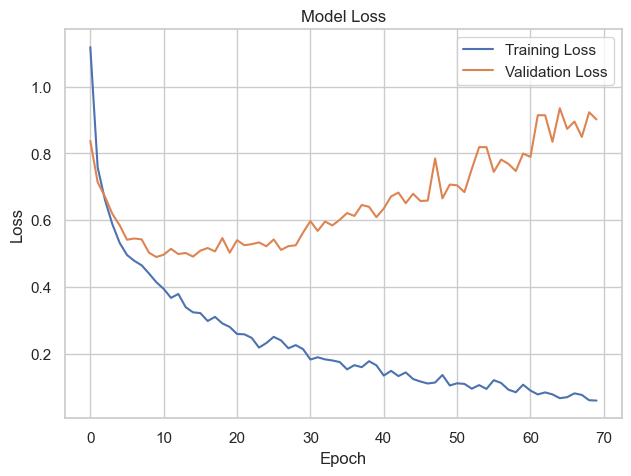

In [61]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

A second approach: Pitch bend

In [64]:
file_path = 'C:\\Users\\gabri\\OneDrive\\Desktop\\MSAAI\\AAI-511\\aai-511_group1\\midiclassics'

In [69]:
def extract_pitch_bend_features(file_path):
    midi_data = pm.PrettyMIDI(file_path)
    pitch_bends = [pb for instrument in midi_data.instruments for pb in instrument.pitch_bends]
    
    if pitch_bends:
        pitch_bend_amounts = [pb.pitch for pb in pitch_bends]
        features = {
            'num_pitch_bends': len(pitch_bends),
            'avg_pitch_bend': sum(pitch_bend_amounts) / len(pitch_bend_amounts),
            'max_pitch_bend': max(pitch_bend_amounts),
            'min_pitch_bend': min(pitch_bend_amounts),
            'pitch_bend_density': len(pitch_bends) / midi_data.get_end_time(),
            'pitch_bend_variability': pd.Series(pitch_bend_amounts).std(),
        }
    else:
        features = {
            'num_pitch_bends': 0,
            'avg_pitch_bend': 0,
            'max_pitch_bend': 0,
            'min_pitch_bend': 0,
            'pitch_bend_density': 0,
            'pitch_bend_variability': 0,
        }
    
    return features



In [71]:
def get_composer_from_filename(file_path):
    return os.path.basename(file_path).split('_')[0]

def load_midi_files_to_df(directory_path, composer):
    midi_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.lower().endswith(('.mid', '.midi'))]
    data = []
    for file in midi_files:
        try:
            pitch_bend_features = extract_pitch_bend_features(file)
            features = {**pitch_bend_features, 'composer': composer}
            data.append(features)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    df = pd.DataFrame(data)
    return df

In [72]:
# List of composers (folder names)
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Dictionary to hold DataFrames for each composer
composer_dataframes = {}

random_state = 88

# Process each composer's folder
for composer in composers:
    composer_folder = os.path.join(file_path, composer)
    composer_df = load_midi_files_to_df(composer_folder, composer)
    
    if composer == 'Bach':
        composer_df = composer_df.sample(n=250, random_state=random_state)

    composer_dataframes[composer] = composer_df
    print(f"{composer} DataFrame:")
    print(composer_df.head())

# Merge all DataFrames into a single DataFrame
all_composers_df = pd.concat(composer_dataframes.values(), ignore_index=True)

# Display the merged DataFrame
print("Merged DataFrame:")
print(all_composers_df.head())

c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Bach DataFrame:
     num_pitch_bends  avg_pitch_bend  max_pitch_bend  min_pitch_bend  \
5                  0             0.0               0               0   
824                0             0.0               0               0   
352                0             0.0               0               0   
338                0             0.0               0               0   
737                0             0.0               0               0   

     pitch_bend_density  pitch_bend_variability composer  
5                   0.0                     0.0     Bach  
824                 0.0                     0.0     Bach  
352                 0.0                     0.0     Bach  
338                 0.0                     0.0     Bach  
737                 0.0                     0.0     Bach  
Error processing file C:\Users\gabri\OneDrive\Desktop\MSAAI\AAI-511\aai-511_group1\midiclassics\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Beethoven DataFrame:
   num_pitch_bends  avg_pitch_bend  max_pitch_bend  min_pitch_bend  \
0                0             0.0               0               0   
1                0             0.0               0               0   
2                0             0.0               0               0   
3                0             0.0               0               0   
4                3             0.0               0               0   

   pitch_bend_density  pitch_bend_variability   composer  
0            0.000000                     0.0  Beethoven  
1            0.000000                     0.0  Beethoven  
2            0.000000                     0.0  Beethoven  
3            0.000000                     0.0  Beethoven  
4            0.004847                     0.0  Beethoven  


c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Chopin DataFrame:
   num_pitch_bends  avg_pitch_bend  max_pitch_bend  min_pitch_bend  \
0                0             0.0               0               0   
1                0             0.0               0               0   
2                0             0.0               0               0   
3                0             0.0               0               0   
4                0             0.0               0               0   

   pitch_bend_density  pitch_bend_variability composer  
0                 0.0                     0.0   Chopin  
1                 0.0                     0.0   Chopin  
2                 0.0                     0.0   Chopin  
3                 0.0                     0.0   Chopin  
4                 0.0                     0.0   Chopin  


c:\Users\gabri\anaconda3\envs\tf\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing file C:\Users\gabri\OneDrive\Desktop\MSAAI\AAI-511\aai-511_group1\midiclassics\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Mozart DataFrame:
   num_pitch_bends  avg_pitch_bend  max_pitch_bend  min_pitch_bend  \
0                0             0.0               0               0   
1                0             0.0               0               0   
2                0             0.0               0               0   
3                0             0.0               0               0   
4                0             0.0               0               0   

   pitch_bend_density  pitch_bend_variability composer  
0                 0.0                     0.0   Mozart  
1                 0.0                     0.0   Mozart  
2                 0.0                     0.0   Mozart  
3                 0.0                     0.0   Mozart  
4                 0.0                     0.0   Mozart  
Merged DataFrame:
   num_pitch_bends  a

In [74]:
all_composers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   num_pitch_bends         855 non-null    int64  
 1   avg_pitch_bend          855 non-null    float64
 2   max_pitch_bend          855 non-null    int64  
 3   min_pitch_bend          855 non-null    int64  
 4   pitch_bend_density      855 non-null    float64
 5   pitch_bend_variability  852 non-null    float64
 6   composer                855 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 46.9+ KB


In [75]:
all_composers_df.describe()

,num_pitch_bends,avg_pitch_bend,max_pitch_bend,min_pitch_bend,pitch_bend_density,pitch_bend_variability
count,855.000000,855.000000,855.000000,855.000000,855.000000,852.000000
mean,1.512281,-27.905730,-14.880702,-44.805848,0.002848,10.634798
std,4.492724,486.416522,507.764257,507.090874,0.009349,102.430691
min,0.000000,-8192.000000,-8192.000000,-8192.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1023.875000,4095.000000,0.000000,0.071773,2766.795530


In [76]:
all_composers_df['composer'].value_counts()

composer
Mozart       254
Bach         250
Beethoven    217
Chopin       134
Name: count, dtype: int64

In [ ]:
# 1. Preprocess the Data

# Encode the target labels (composers)
label_encoder = LabelEncoder()
all_composers_df['composer'] = label_encoder.fit_transform(all_composers_df['composer'])

# Separate features and target
X = all_composers_df.drop('composer', axis=1)
y = all_composers_df['composer']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_state)

In [80]:
# 2. Define the Neural Network

model_2 = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax activation for multiclass classification
])



In [82]:
# Compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [83]:
# 3. Train the Model

history_2 = model_2.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, verbose=1)


Epoch 1/50
18/18 [==============================] - 0s 8ms/step - loss: 1.3835 - accuracy: 0.2651 - val_loss: 1.3839 - val_accuracy: 0.2482
Epoch 2/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3671 - accuracy: 0.2998 - val_loss: 1.3848 - val_accuracy: 0.2482
Epoch 3/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3580 - accuracy: 0.2998 - val_loss: 1.3883 - val_accuracy: 0.2482
Epoch 4/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3531 - accuracy: 0.2998 - val_loss: 1.3904 - val_accuracy: 0.2482
Epoch 5/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3510 - accuracy: 0.2962 - val_loss: 1.3977 - val_accuracy: 0.2482
Epoch 6/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3495 - accuracy: 0.3126 - val_loss: 1.4000 - val_accuracy: 0.2482
Epoch 7/50
18/18 [==============================] - 0s 2ms/step - loss: 1.3498 - accuracy: 0.3126 - val_loss: 1.4023 - val_accuracy: 0.2482
Epoch 8/50
18/18 [==

In [84]:
# 4. Evaluate the Model

test_loss, test_accuracy = model_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 5. Make Predictions

predictions = model_2.predict(X_test)
predicted_classes = predictions.argmax(axis=1)

# Optionally, decode the predicted classes back to composer names
# predicted_composers = label_encoder.inverse_transfor(predicted_classes)m

6/6 [==============================] - 0s 0s/step - loss: 1.3608 - accuracy: 0.2632
Test Accuracy: 26.32%
6/6 [==============================] - 0s 39us/step


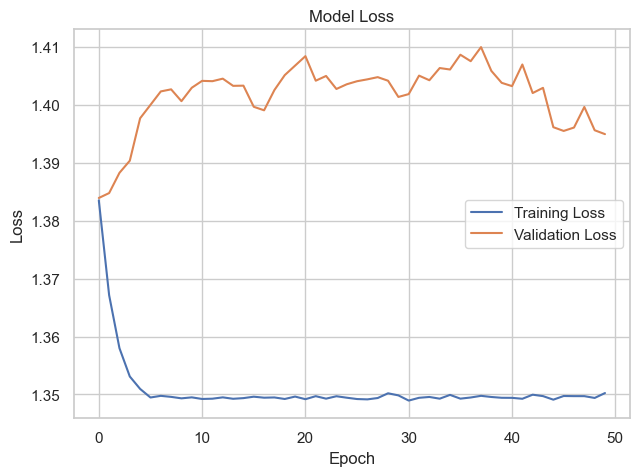

In [86]:
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Working on dashboard: 

In [62]:
# joblib.dump(model, 'draft_lstm.pkl')

# joblib.dump(column_transformer, 'column_transfomer.pkl')

In [63]:
# modelo = load_model('draft_lstm.h5')